# Efficient Sub-Pixel CNN on BSDS500

References:

- W. Shi et al., "Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 1874-1883, doi: 10.1109/CVPR.2016.207. https://arxiv.org/pdf/1609.05158.pdf
- Image Super-Resolution using Efficient Sub-Pixel CNN. Keras tutorials. https://keras.io/examples/vision/super_resolution_sub_pixel/

In [1]:
import tensorflow as tf

In [2]:
class Config:
    class run:
        seed = 6928

    class data:
        crop_size = 300
        upscale_factor = 3
        input_size = crop_size // upscale_factor
        channels = 1
        
        input_shape = (input_size, input_size, 3)
        
        batch_size = 8
        buffer_size = 32
    
    class model:
        conv_default_args = {
            "kernel_initializer": "Orthogonal",
            "padding": "same",
            'activation': 'swish'
        }
        
    class training:
        epochs = 100
        logs = '../../../logs/subpixel/bsds500'

## Setup

In [3]:
import math, json, os, shutil

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sns.set()

rs = np.random.RandomState(Config.run.seed)
C = plt.get_cmap('tab10').colors

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e: print(e)

### Utils Functions

In [6]:
def normalize(x, axis=None):
    return tf.math.divide_no_nan(x, tf.reduce_max(x, axis=axis, keepdims=True))

def array_to_img(x):
    x = normalize(x)
    return tf.cast(tf.clip_by_value(x, 0, 1) * 255, tf.int16)

def display_images(images, rows=1, cols=None, size=(12, 6)):
    cols = cols or math.ceil(len(images) / rows)

    plt.figure(figsize=size)
    for ix, i in enumerate(images):
        plt.subplot(rows, cols, ix + 1)
        plt.imshow(array_to_img(i))
        plt.axis('off')
    plt.tight_layout()

## Dataset

In [7]:
data_dir = tf.keras.utils.get_file(
    origin='http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz',
    fname="BSR",
    untar=True)
root_dir = os.path.join(data_dir, 'BSDS500/data')

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir,
    batch_size=Config.data.batch_size,
    image_size=(Config.data.crop_size, Config.data.crop_size),
    validation_split=0.2,
    subset="training",
    seed=rs.randint(10000),
    label_mode=None,
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir,
    batch_size=Config.data.batch_size,
    image_size=(Config.data.crop_size, Config.data.crop_size),
    validation_split=0.2,
    subset="validation",
    seed=rs.randint(10000),
    label_mode=None,
)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


### Original Images

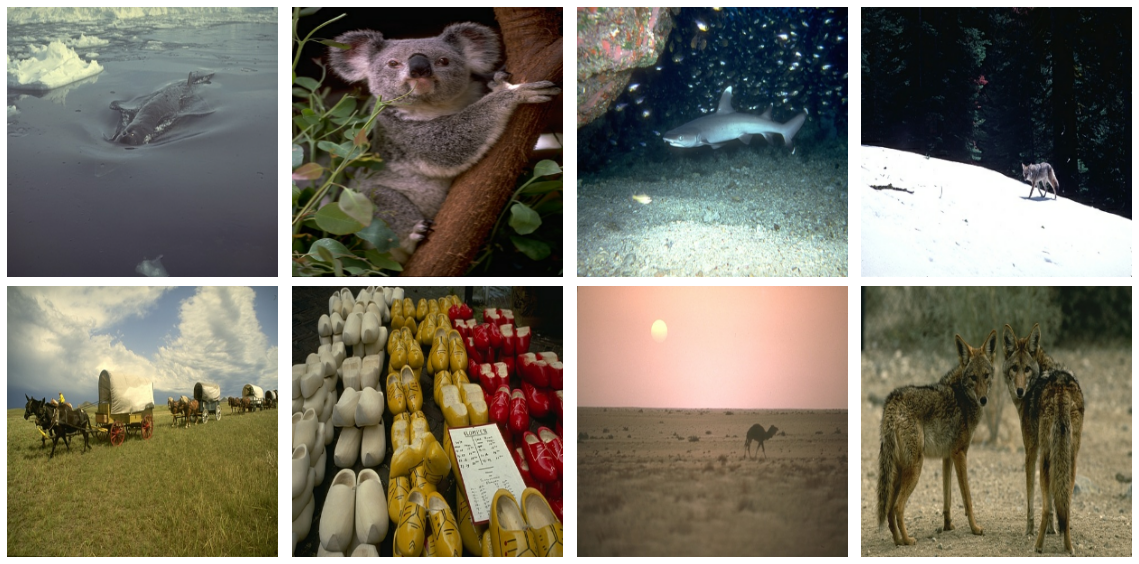

In [9]:
for images in train_ds.take(1):
    display_images(images, rows=2, size=(16, 8))

In [10]:
train_data = (train_ds
              .map(lambda x: (tf.image.resize(x, Config.data.input_shape[:2], method='area'), x))
              .prefetch(buffer_size=Config.data.buffer_size))

valid_data = (valid_ds
              .map(lambda x: (tf.image.resize(x, Config.data.input_shape[:2], method='area'), x))
              .prefetch(buffer_size=Config.data.buffer_size))

images: (8, 100, 100, 3) <dtype: 'float32'>
labels: (8, 300, 300, 3) <dtype: 'float32'>


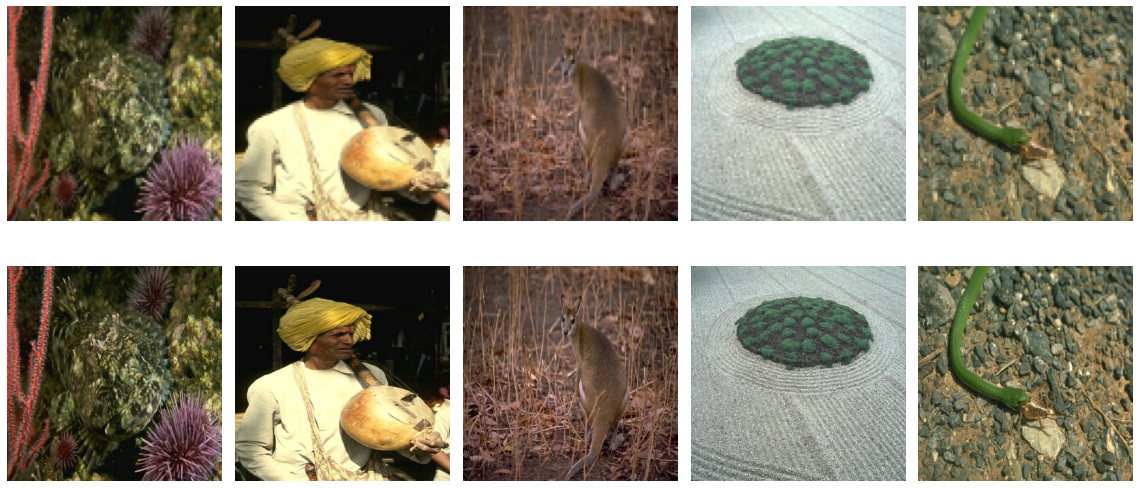

In [12]:
N = 5

for images, labels in train_data.take(1):
    print('images:', images.shape, images.dtype)
    print('labels:', labels.shape, labels.dtype)

    display_images((*images[:N], *labels[:N]),
                   rows=2, size=(16, 8))

## Network

In [13]:
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import Lambda, Conv2D, Activation, experimental

shape = Config.data.input_shape
upscale_factor = Config.data.upscale_factor
channels = Config.data.channels

espcnet = Sequential([
    Input(shape=shape, name='images'),
    experimental.preprocessing.Rescaling(1 / 255., name='rescaling'),
    Lambda(lambda x: tf.image.rgb_to_yuv(x)[..., :1], name='rgb_to_y'),
    Conv2D(64, 5, name='cv1', **Config.model.conv_default_args),
    Conv2D(64, 3, name='cv2', **Config.model.conv_default_args),
    Conv2D(32, 3, name='cv3', **Config.model.conv_default_args),
    Conv2D(channels * (upscale_factor ** 2), 3, name='upscale', **Config.model.conv_default_args),
    Lambda(lambda x: tf.nn.depth_to_space(x, upscale_factor), name='depth_to_space')
], name='espcnet')

In [14]:
class ESPCDecoder(tf.keras.layers.Layer):
    def call(self, inputs):
        inputs, reconstructed = inputs

        return reconstructed
#         y = tf.clip_by_value(x * 255., 0, 255)
#         out_img_y = out_img_y.clip(0, 255)
#         out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
#         out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
#         out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
#         out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
#         out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
#             "RGB"
#         )


def build_decoder(espc_backbone):
    x = espc_backbone.input
    y = espc_backbone.output
    y = ESPCDecoder(name='yuv_to_rgb')([x, y])
    
    return Model(
        inputs=x,
        outputs=y,
        name='espcnet_decoder')

espcnet_d = build_decoder(espcnet)

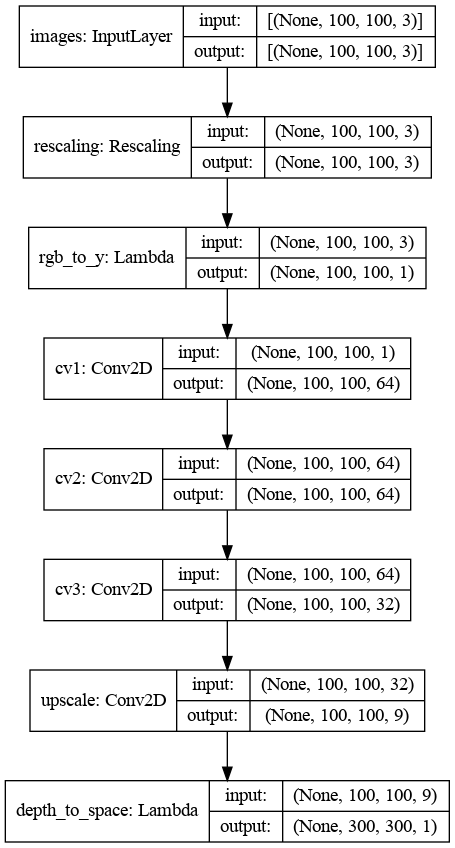

In [15]:
tf.keras.utils.plot_model(espcnet, show_shapes=True)

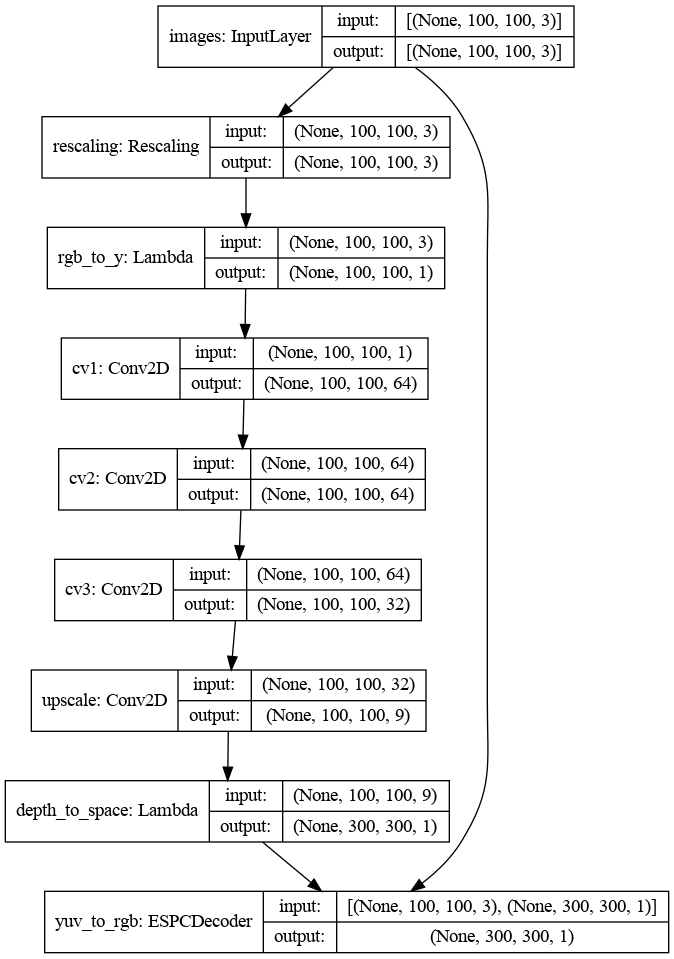

In [16]:
tf.keras.utils.plot_model(espcnet_d, show_shapes=True, expand_nested=True)

## Training

In [ ]:

def y_mean_squared_error(y_true, y_pred):
    """Y Coefficient Mean Squared Error.
    
    Convert an input image from RGB (0, 255) to YUV.
    Used as loss function to the model above.
    """
    y = tf.image.rgb_to_yuv(y_true / 255.)[..., :1]
    return tf.losses.mean_squared_error(y, y_pred)




In [ ]:
from tensorflow.keras import callbacks

class ESPCNCallback(callbacks.Callback):
    def __init__(self, logdir, data):
        super().__init__()
        self.logdir = logdir
        self.data = data
        
        self.writer = None
    
    def on_train_begin(self):
        if self.writer is None:
            self.writer = tf.summary.create_file_writer(logdir + '/cm')
    
    def on_train_end(self):
        self.writer.close()
    
    def on_epoch_end(self, epoch, logs=None):
        output = self.model.predict(self.data)
        
        self.model(self.data, training=False)
        
        with self.writer.as_default():
            tf.summary.image('Reconstruction examples', img, step=epoch)

In [ ]:

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss='mse')

try: model.fit(train_ds,
               epochs=2,  # Config.training.epochs,
               validation_data=valid_ds,
               callbacks=[# ESPCNCallback(),
                          callbacks.TensorBoard(Config.training.logs),
                          callbacks.EarlyStopping(monitor="loss", patience=10),
                          callbacks.ModelCheckpoint(
                              filepath=Config.training.logs + '/weights.h5',
                              save_weights_only=True,
                              save_best_only=True,
                          )],
               verbose=2)
except KeyboardInterrupt: print('\ninterrupted')
else: print('done')

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)
